## March Madness Logistic Regression

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import numpy as np
import pandas as pd
from sklearn.cross_validation import train_test_split
from sklearn.externals import joblib
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (auc, classification_report, roc_auc_score, accuracy_score,
                             f1_score, log_loss, roc_curve, confusion_matrix, precision_score, recall_score)
from sklearn.preprocessing import StandardScaler
from math import sin, cos, sqrt, atan2, radians
import random
import statsmodels.api as sm
from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)

/Users/tpetersen/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/tpetersen/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
def distance(lat1, lon1, lat2, lon2):

    # approximate radius of earth in km
    R = 6373.0

    lat1 = radians(lat1)
    lon1 = radians(lon1)
    lat2 = radians(lat2)
    lon2 = radians(lon2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c
    
    return distance

In [3]:
mm_data = pd.read_csv('NCAA_Tourney_2002-2016.csv')

In [4]:
mm_data.columns

Index(['Numot', 'Season', 'game_id', 'host_lat', 'host_long', 'host_site',
       'season', 'team1_id', 'team1_score', 'team2_id', 'team2_score',
       'team1_seed', 'team1_lat', 'team1_long', 'team1_teamname',
       'team1_fg2pct', 'team1_fg3pct', 'team1_ftpct', 'team1_blockpct',
       'team1_oppfg2pct', 'team1_oppfg3pct', 'team1_oppftpct',
       'team1_oppblockpct', 'team1_f3grate', 'team1_oppf3grate', 'team1_arate',
       'team1_opparate', 'team1_stlrate', 'team1_oppstlrate', 'team1_tempo',
       'team1_adjtempo', 'team1_oe', 'team1_adjoe', 'team1_de', 'team1_adjde',
       'team1_ap_preseason', 'team1_ap_final', 'team1_coaches_preseason',
       'team1_coaches_before_final', 'team1_rpi_rating', 'team1_coach_id',
       'team1_coach_name', 'team1_pt_school_ncaa', 'team1_pt_overall_ncaa',
       'team1_pt_school_s16', 'team1_pt_overall_s16', 'team1_pt_school_ff',
       'team1_pt_overall_ff', 'team1_pt_career_school_wins',
       'team1_pt_career_school_losses', 'team1_pt_caree

In [5]:
mm_data['dist1'] = mm_data.apply(lambda row: distance(row['host_lat'], row['host_long'], row['team1_lat'], row['team1_long']), axis=1)
mm_data['dist2'] = mm_data.apply(lambda row: distance(row['host_lat'], row['host_long'], row['team2_lat'], row['team2_long']), axis=1)

In [6]:
mm_data['diff_dist'] = mm_data['dist1'] - mm_data['dist2']

## Pythag College Basketball
E(W%) = points scored^11.5 / (points scored^11.5+points allowed^11.5)

In [7]:
mm_data['exp_win1'] = (mm_data['team1_adjoe']**11.5)/ ((mm_data['team1_adjde']**11.5)+(mm_data['team1_adjoe']**11.5))
mm_data['exp_win2'] = (mm_data['team2_adjoe']**11.5)/ ((mm_data['team2_adjde']**11.5)+(mm_data['team2_adjoe']**11.5))

## Log 5
P(W) = (A - A * B) / (A + B - 2*A*B)

In [8]:
mm_data['team1_log5'] = (mm_data['exp_win1'] - (mm_data['exp_win1']*mm_data['exp_win2']))/ (mm_data['exp_win1']+mm_data['exp_win2']-(2*mm_data['exp_win1']*mm_data['exp_win2']))

In [9]:
mm_data[['team1_adjoe','team1_teamname','season','team2_teamname','team1_adjde','exp_win1','exp_win2','team1_log5']].head()

,team1_adjoe,team1_teamname,season,team2_teamname,team1_adjde,exp_win1,exp_win2,team1_log5
0,111.4954,Alabama,2002,Florida Atlantic,93.8770,0.878465,0.411542,0.911780
1,117.3877,Arizona,2002,UC Santa Barbara,96.9262,0.900485,0.707177,0.789333
2,109.6136,Indiana,2002,Utah,89.9224,0.906968,0.812015,0.692962
3,115.0406,Kansas,2002,Holy Cross,90.5399,0.940149,0.501475,0.939816
4,113.6686,Kent St.,2002,Oklahoma St.,96.2010,0.871998,0.809638,0.615641


## Seed Diff

In [10]:
mm_data['seed_diff'] = mm_data['team1_seed'] - mm_data['team2_seed']

In [11]:
mm_data[['game_id','exp_win1','exp_win2','team2_score','team1_score','diff_dist','team1_log5','team1_id','team2_id']].head()

,game_id,exp_win1,exp_win2,team2_score,team1_score,diff_dist,team1_log5,team1_id,team2_id
0,2002-1104-1194,0.878465,0.411542,78,86,-88.820532,0.911780,1104,1194
1,2002-1112-1364,0.900485,0.707177,81,86,-697.542289,0.789333,1112,1364
2,2002-1231-1428,0.906968,0.812015,56,75,2148.977013,0.692962,1231,1428
3,2002-1242-1221,0.940149,0.501475,59,70,-39.535171,0.939816,1242,1221
4,2002-1245-1329,0.871998,0.809638,61,69,-1066.404958,0.615641,1245,1329


## Split Data

In [12]:
mm_data.dropna(subset=['team1_log5'], inplace=True)

In [13]:
mm_data['team1_win'] = mm_data['result']

In [14]:
def shuffle(df):     
    df = df.reindex(np.random.permutation(df.index)).copy()
    return df.reset_index(drop=True)

In [15]:
my_randoms = random.sample(range(len(mm_data)), int(len(mm_data)/2))
mm_data[(~mm_data.index.isin(my_randoms))&(mm_data.season==2015)].shape

(35, 108)

In [16]:
mm_data = shuffle(mm_data)

In [17]:
my_randoms = random.sample(range(len(mm_data)), int(len(mm_data)/2))

In [18]:
mm_data[(~mm_data.index.isin(my_randoms))&(mm_data.season==2015)].shape

(44, 108)

In [19]:
mm_data_1 = mm_data[~mm_data.index.isin(my_randoms)][['game_id','season','team1_win','exp_win1','exp_win2','team2_score',
                                                      'team1_score','diff_dist','team1_log5','team1_id','team2_id','seed_diff']].reset_index(drop=True)
mm_data_2 = mm_data[mm_data.index.isin(my_randoms)][['game_id','season','team1_win','exp_win1','exp_win2','team2_score',
                                    'team1_score','diff_dist','team1_log5','team1_id','team2_id','seed_diff']].reset_index(drop=True)

In [20]:
mm_data_2['team1_win'] = mm_data_2['team1_win'].apply(lambda x: 1 if x==0 else 0)
mm_data_2['diff_dist'] = mm_data_2['diff_dist']*-1
mm_data_2['team1_log5'] = 1-mm_data_2['team1_log5']
mm_data['seed_diff'] = mm_data['seed_diff']*-1
mm_data_2.columns = ['game_id', 'season', 'team1_win', 'exp_win2', 'exp_win1', 'team1_score', 'team2_score', 'diff_dist', 'team1_log5',
 'team2_id', 'team1_id','seed_diff']

In [21]:
mm_train = pd.concat([mm_data_2, mm_data_1])

In [22]:
mm_data_2016 = mm_train[mm_train['season'] == 2016].reset_index(drop=True)
mm_data_else =  mm_train[mm_train['season'] != 2016].reset_index(drop=True)

## Initial Check

In [23]:
mm_data_else.groupby('team1_win')['team1_log5'].mean()

team1_win
0    0.364922
1    0.609663
Name: team1_log5, dtype: float64

In [24]:
mm_data_else.groupby('team1_win')['seed_diff'].mean()

team1_win
0   -0.110855
1   -0.012552
Name: seed_diff, dtype: float64

In [25]:
mm_data_else.groupby('team1_win')['diff_dist'].mean()

team1_win
0    169.166237
1   -145.572198
Name: diff_dist, dtype: float64

## Train Logit

In [26]:
scaler = StandardScaler()
mm_train_scaled = scaler.fit_transform(mm_data_else[['team1_log5']])
logit = LogisticRegression()
logit.fit(mm_train_scaled, mm_data_else['team1_win'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [27]:
smlogit = sm.Logit(mm_data_else['team1_win'], mm_data_else['team1_log5']).fit()
smlogit.summary()

Optimization terminated successfully.
         Current function value: 0.656464
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              team1_win   No. Observations:                  911
Model:                          Logit   Df Residuals:                      910
Method:                           MLE   Df Model:                            0
Date:                Tue, 27 Feb 2018   Pseudo R-squ.:                 0.05125
Time:                        17:39:17   Log-Likelihood:                -598.04
converged:                       True   LL-Null:                       -630.35
                                        LLR p-value:                       nan
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
team1_log5     1.0231      0.129      7.927      0.000       0.770       1.276
==============================================================================
"""

In [28]:
mm_data_2016['preds'] = logit.predict_proba(scaler.fit_transform(mm_data_2016[['team1_log5']]))[:,1]
mm_data_2016['prediction'] = logit.predict(scaler.fit_transform(mm_data_2016[['team1_log5']]))

In [29]:
mm_data_2016[['team1_log5','team1_win','preds','prediction']].head()

,team1_log5,team1_win,preds,prediction
0,0.542750,0,0.597609,1
1,0.707548,1,0.797188,1
2,0.430202,1,0.433103,0
3,0.255550,0,0.214047,0
4,0.836018,1,0.893553,1


In [30]:
mm_data_2016.groupby('team1_win')['preds'].mean()

team1_win
0    0.371381
1    0.650107
Name: preds, dtype: float64

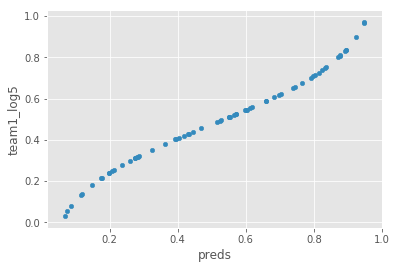

In [31]:
mm_data_2016.plot(kind='scatter', x='preds',y='team1_log5')

In [32]:
confusion_matrix(mm_data_2016['team1_win'], mm_data_2016['prediction'])

array([[20, 10],
       [ 9, 28]])

In [33]:
accuracy_score(mm_data_2016['team1_win'], mm_data_2016['prediction'],)

0.71641791044776115

In [34]:
precision_score(mm_data_2016['team1_win'], mm_data_2016['prediction'])

0.73684210526315785

In [35]:
recall_score(mm_data_2016['team1_win'], mm_data_2016['prediction'])

0.7567567567567568

In [36]:
f1_score(mm_data_2016['team1_win'], mm_data_2016['prediction'])

0.7466666666666667

In [37]:
log_loss(mm_data_2016['team1_win'].values, mm_data_2016['preds'].values)

0.53388455050819317

In [38]:
def plot_roc(fpr, tpr, roc_auc):
    """Plots the ROC curve for the win probability model along with
    the AUC.
    """
    fig, ax = plt.subplots()
    ax.set(title='Receiver Operating Characteristic',
           xlim=[0, 1], ylim=[0, 1], xlabel='False Positive Rate',
           ylabel='True Positive Rate')
    ax.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.legend(loc='lower right')

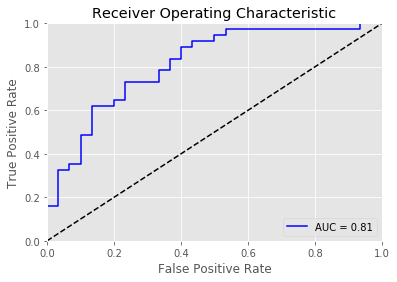

In [39]:
fpr, tpr, thresholds = roc_curve(mm_data_2016['team1_win'].values, mm_data_2016['preds'].values)
roc_auc = auc(fpr, tpr)
plot_roc(fpr, tpr, roc_auc)

In [40]:
roc_auc_score(mm_data_2016['team1_win'].values, mm_data_2016['preds'].values)

0.81261261261261264

## Add Seed Difference & Distance

In [41]:
scaler = StandardScaler()
mm_train_scaled = scaler.fit_transform(mm_data_else[['team1_log5','diff_dist','seed_diff']])
logit = LogisticRegression()
logit.fit(mm_train_scaled, mm_data_else['team1_win'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [42]:
smlogit = sm.Logit(mm_data_else['team1_win'], mm_data_else[['team1_log5','diff_dist','seed_diff']]).fit()
smlogit.summary()

Optimization terminated successfully.
         Current function value: 0.648941
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              team1_win   No. Observations:                  911
Model:                          Logit   Df Residuals:                      908
Method:                           MLE   Df Model:                            2
Date:                Tue, 27 Feb 2018   Pseudo R-squ.:                 0.06212
Time:                        17:39:20   Log-Likelihood:                -591.19
converged:                       True   LL-Null:                       -630.35
                                        LLR p-value:                 9.840e-18
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
team1_log5     1.0077      0.130      7.734      0.000       0.752       1.263
diff_dist     -0.0002   6.12e-05     -3.645      0.000      -0.000      -0.000
seed_diff      0.0018      0.009      0.192      0.848      -0.016       0.020
==============================================================================
"""

In [43]:
mm_data_2016['preds'] = logit.predict_proba(scaler.fit_transform(mm_data_2016[['team1_log5','diff_dist','seed_diff']]))[:,1]
mm_data_2016['prediction'] = logit.predict(scaler.fit_transform(mm_data_2016[['team1_log5','diff_dist','seed_diff']]))

In [44]:
accuracy_score(mm_data_2016['team1_win'], mm_data_2016['prediction'],)

0.74626865671641796

In [45]:
precision_score(mm_data_2016['team1_win'], mm_data_2016['prediction'])

0.77777777777777779

In [46]:
recall_score(mm_data_2016['team1_win'], mm_data_2016['prediction'])

0.7567567567567568

In [47]:
f1_score(mm_data_2016['team1_win'], mm_data_2016['prediction'])

0.76712328767123283

In [48]:
log_loss(mm_data_2016['team1_win'].values, mm_data_2016['preds'].values)

0.525781043449986

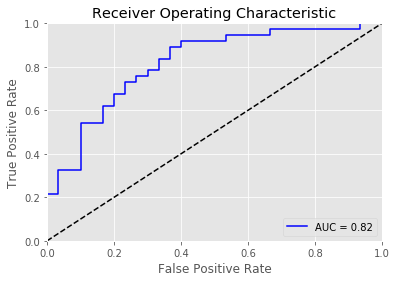

In [49]:
fpr, tpr, thresholds = roc_curve(mm_data_2016['team1_win'].values, mm_data_2016['preds'].values)
roc_auc = auc(fpr, tpr)
plot_roc(fpr, tpr, roc_auc)

In [50]:
roc_auc_score(mm_data_2016['team1_win'].values, mm_data_2016['preds'].values)

0.81621621621621621